<a href="https://colab.research.google.com/github/Nekesa-kod/ALX-Data-Science-Project/blob/main/Space_awareness.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings('ignore')



Two-line elements(TLEs) is a standardised format used to describe the orbit of a satellite. They consist of a set of data that includes important orbital parameters, such as the satellite's position, velocity, and other relevant information at a specific time.

Using SGP4 propagation, we can compute the satellite’s position and velocity at any time.


In [ ]:
#pip install sgp4

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.7/235.7 kB 7.4 MB/s eta 0:00:00


The dataset is a collection of Conjunction Data Messages (CDMs) received by ESA from 2015 to 2019. The CDMs have been anonymised for distribution. The initial raw data, as well as the labels that were kept private during the competition, are also released.
ESA thanks the US Space Surveillance Network for the provision of surveillance data supporting safe operations of ESA’s spacecraft. In addition, we are grateful to the agreement which allows to publicly release the current dataset.

The dataset is represented as a table, where each row corresponds to a single CDM, and each CDM contains 103 recorded characteristics/features. There are thus 103 columns, which are described in the competition pages. The dataset is made of several unique collision/close approach events, which are identified in the event_id column. In turn, each collision event is made of several CDMs recorded over time. Therefore, a single collision event can be thought of as a times series of CDMs. From these CDMs, for every collision event, we are interested in predicting the final risk which is computed in the last CDM of the time series (i.e. the risk value in the last row of each collision event).

In [40]:
train_df = pd.read_csv('/content/train_data.zip')
test_df = pd.read_csv('/content/test_data.csv')
print("Training Data Shape:", train_df.shape)
print("Testing Data Shape:", test_df.shape)

Training Data Shape: (162634, 103)
Testing Data Shape: (24484, 103)


The dataset is a collection of Conjunction Data Messages (CDMs) received by ESA from 2015 to 2019. The CDMs have been anonymised for distribution. The initial raw data, as well as the labels that were kept private during the competition, are also released.
ESA thanks the US Space Surveillance Network for the provision of surveillance data supporting safe operations of ESA’s spacecraft. In addition, we are grateful to the agreement which allows to publicly release the current dataset.

The dataset is represented as a table, where each row corresponds to a single CDM, and each CDM contains 103 recorded characteristics/features. The dataset is made of several unique collision/close approach events, which are identified in the event_id column. In turn, each collision event is made of several CDMs recorded over time. Therefore, a single collision event can be thought of as a times series of CDMs. From these CDMs, for every collision event, we are interested in predicting the final risk which is computed in the last CDM of the time series (i.e. the risk value in the last row of each collision event).

#Data Exploration and preparation.


In [66]:
test_df.head()

,event_id,time_to_tca,mission_id,risk,max_risk_estimate,max_risk_scaling,miss_distance,relative_speed,relative_position_r,relative_position_t,...,t_sigma_rdot,c_sigma_rdot,t_sigma_tdot,c_sigma_tdot,t_sigma_ndot,c_sigma_ndot,F10,F3M,SSN,AP
0,0,6.842095,19,-7.296967,-7.208941,1.787894,31816.0,7929.0,-365.5,26967.0,...,0.371943,29.669476,0.007763,0.223996,0.011833,1.375099,76.0,74.0,29.0,11.0
1,0,6.571818,19,-7.282496,-7.199833,1.759386,31095.0,7929.0,-361.8,26356.6,...,0.364986,29.460828,0.007762,0.223983,0.011833,1.375117,75.0,74.0,24.0,9.0
2,0,6.112986,19,-7.316053,-7.217886,1.824263,32202.0,7929.0,-370.7,27294.4,...,0.303518,29.747208,0.008190,0.223999,0.010530,1.375092,75.0,74.0,24.0,9.0
3,0,5.921955,19,-7.334138,-7.228707,1.865396,32878.0,7929.0,-376.3,27867.5,...,0.295359,29.926660,0.007698,0.224004,0.010449,1.375077,75.0,74.0,24.0,9.0
4,0,2.228761,19,-7.332267,-7.227312,1.863127,32792.0,7929.0,-375.6,27793.8,...,0.056579,29.845809,0.006125,0.224004,0.007821,1.375085,71.0,73.0,0.0,4.0


In [41]:
missing_values = train_df.isnull().sum().sort_values(ascending=False)
missing_values = missing_values[missing_values > 0]
#print(missing_values)
len(missing_values)

50

Out of 103 columns, we have 50 columns with missing values as stated above.

In [42]:
#removing low variance features
from sklearn.feature_selection import VarianceThreshold

# Drop the non-numeric column 'c_object_type'
if 'c_object_type' in train_df.columns:
    train_df_numeric = train_df.drop(columns=['c_object_type'])
else:
    train_df_numeric = train_df.copy()

selector = VarianceThreshold(threshold=0.01)  # keep features with variance > 0.01
reduced_data = selector.fit_transform(train_df_numeric.fillna(0))
train_df_reduced = pd.DataFrame(reduced_data, columns=train_df_numeric.columns[selector.get_support()])
train_df_reduced.drop(columns=['risk'], inplace=True)
train_df_reduced.shape

(162634, 90)

In [43]:
#using correlation to reduce redundancy
corr_matrix = train_df_reduced.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]
train_df_reduced = train_df_reduced.drop(to_drop, axis=1)
train_df_reduced.shape

(162634, 62)

In [44]:
#using Principal Component Analysis (PCA) to compress 103 features into fewer synthetic ones
 #(e.g., 10–20) that capture most of the variance.

scaler = StandardScaler()
X_scaled = scaler.fit_transform(train_df_reduced.fillna(0))

pca = PCA(n_components=20)  # reduce to 20 features
X_pca = pca.fit_transform(X_scaled)

X_pca_df = pd.DataFrame(X_pca, columns=[f'PC{i+1}' for i in range(20)])
X_pca_df.shape

(162634, 20)

Your new dataset has 20 compressed features (PC1 … PC20) + your risk column(to be added back to the dataset). Each PC is a linear combination of our original features (so the information is still there, but compressed)

Our target variable, 'Risk' is however nor part of it. Next we will use a heatmap to show correlation between features.

In [45]:
# Add the 'risk' column back to the PCA DataFrame
X_pca_df['risk'] = train_df['risk']
X_pca_df.shape

(162634, 21)

#Heatmap
This is neccessary for optimizing variable selection by checking corelation between features.

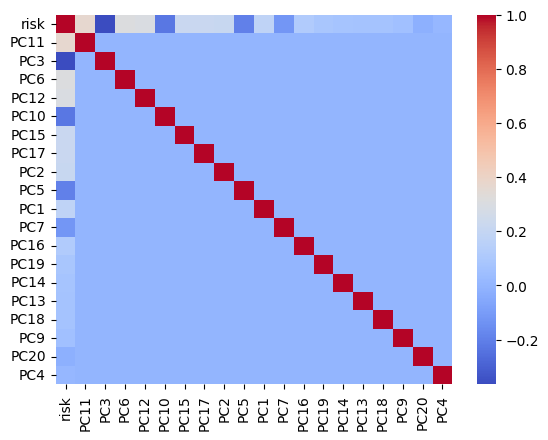

In [36]:
import seaborn as sns
import matplotlib.pyplot as plt

# Example: heatmap of correlation of top 20 features
top_features = X_pca_df.corr().abs().nlargest(20, "risk").index  # replace 'target' with your y column
sns.heatmap(X_pca_df[top_features].corr(), annot=False, cmap="coolwarm")
plt.show()

The diagonal red = self-correlation (always 1).

The mostly blue background between PCs = low correlation → meaning PCA has successfully produced uncorrelated features (that’s its job).

The correlation of risk with the PCs (top row/first column) shows which principal components have some relationship with our target.

In [48]:
# Prep the test set
# --- Test data processing ---

# Drop the non-numeric column 'c_object_type'
if 'c_object_type' in test_df.columns:
    test_df_numeric = test_df.drop(columns=['c_object_type'])
else:
    test_df_numeric = test_df.copy()

# Apply the same variance threshold (using selector fitted on train)
reduced_test = selector.transform(test_df_numeric.fillna(0))
test_df_reduced = pd.DataFrame(reduced_test, columns=train_df_numeric.columns[selector.get_support()])

# Drop target column if it exists (risk)
if 'risk' in test_df_reduced.columns:
    test_df_reduced = test_df_reduced.drop(columns=['risk'])

# Drop the same correlated columns as train (using to_drop list from train)
test_df_reduced = test_df_reduced.drop(columns=[col for col in to_drop if col in test_df_reduced.columns])

# Scale using scaler fitted on train
X_test_scaled = scaler.transform(test_df_reduced.fillna(0))

# PCA using pca fitted on train
X_test_pca = pca.transform(X_test_scaled)

# Final dataframe
X_test_pca_df = pd.DataFrame(X_test_pca, columns=[f'PC{i+1}' for i in range(20)])

# Add risk column back (if available in test data)
if 'risk' in test_df.columns:
    X_test_pca_df['risk'] = test_df['risk'].values

X_test_pca_df.shape


(24484, 21)

#Model Building

*   Random Forest
*   LGBM gradient boosting
*   Logistic Regression



In [49]:
# Define Features & Target ===
# ⚠️ Assumption: Let's assume 'risk' is the label (negative = low risk, higher = high risk).
X = X_pca_df.drop(columns=["risk"])   # Features
y = (X_pca_df["risk"] > -7.25).astype(int)
# 👆 Example threshold: mark 1 = potential collision, 0 = safe
X_train, X_val, y_train, y_val = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

In [52]:
# Baseline Model: Random Forest ===
rf_model = RandomForestClassifier(
    n_estimators=200,
    random_state=42,
    class_weight="balanced")

rf_model.fit(X_train, y_train)

rf_val_preds = rf_model.predict(X_val)
print("\nRandom Forest Performance on Validation:")
print(classification_report(y_val, rf_val_preds))



Random Forest Performance on Validation:
              precision    recall  f1-score   support

           0       0.93      1.00      0.96     27693
           1       0.97      0.58      0.72      4834

    accuracy                           0.93     32527
   macro avg       0.95      0.79      0.84     32527
weighted avg       0.94      0.93      0.93     32527



In [54]:
#applying the modelon the test data
X_test = X_test_pca_df.drop(columns=['risk'])
y_test = (X_test_pca_df['risk'] > -7.25).astype(int)

rf_test_preds = rf_model.predict(X_test)
print("\nRandom Forest Performance on Test:")
print(classification_report(y_test, rf_test_preds))


Random Forest Performance on Test:
              precision    recall  f1-score   support

           0       0.79      0.99      0.87     18676
           1       0.76      0.13      0.22      5808

    accuracy                           0.78     24484
   macro avg       0.77      0.56      0.55     24484
weighted avg       0.78      0.78      0.72     24484



The Random Forest achieved high recall (99%) for the majority class (0), but performed very poorly on the minority class (1), with only 13% recall. This indicates a strong bias towards the majority class due to class imbalance. Although the overall accuracy was 78%, the model fails to capture class 1 effectively, making it unreliable for applications where detecting the minority class is critical.

#Gradient boosting using Lightgbm
Above is our baseline model. We can improve it by tuning hyperparameters and using better evaluation.

1. Tune key hyperparameters

n_estimators → number of boosting rounds (more trees can help but risk overfitting).

learning_rate → smaller values (e.g., 0.01–0.1) usually improve generalization but require more trees.

max_depth → controls how deep each tree can grow (default is 3, try 2–6).

subsample → fraction of samples used per tree (e.g., 0.8–0.9 helps regularize).

max_features → number of features to consider per split (try "sqrt" or a fraction).

2. Use GridSearchCV or RandomizedSearchCV

This way, you search for the best parameter combo:

In [56]:
import lightgbm as lgb

lgb_model = lgb.LGBMClassifier(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=-1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

lgb_model.fit(X_train, y_train)
lgb_preds = lgb_model.predict(X_test)

print(classification_report(y_test, lgb_preds))


[LightGBM] [Info] Number of positive: 19338, number of negative: 110769
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.027496 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 130107, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.148632 -> initscore=-1.745375
[LightGBM] [Info] Start training from score -1.745375
              precision    recall  f1-score   support

           0       0.84      0.96      0.89     18676
           1       0.76      0.40      0.52      5808

    accuracy                           0.83     24484
   macro avg       0.80      0.68      0.71     24484
weighted avg       0.82      0.83      0.81     24484



📊 LGBM Performance

Class 0 (majority class, ~18k samples)

Precision = 0.84 → when the model predicts 0, 84% are correct.

Recall = 0.96 → the model catches almost all the real 0’s.

F1 = 0.89 → good balance, the model is strong here.

Class 1 (minority class, ~5.8k samples)

Precision = 0.76 → decent; when it predicts 1, it’s right 76% of the time.

Recall = 0.40 → poor; it only finds 40% of the actual 1’s.

F1 = 0.52 → weak overall because recall is low.

Overall

Accuracy = 0.83 → looks good but misleading, because it mostly comes from class 0.

Macro avg F1 = 0.71 → tells the true story; the model struggles on class 1.

Weighted avg F1 = 0.81 → okay, but still dragged down by poor recall on class 1.

In [59]:
#Add cross-validation
#Instead of one split, do stratified k-fold CV to get more reliable results

from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(
    lgb_model,
    X_train,
    y_train,
    cv=5,
    scoring='f1_macro'
)

print("Cross-validation F1 scores:", cv_scores)
print("Mean CV F1:", cv_scores.mean())


[LightGBM] [Info] Number of positive: 15470, number of negative: 88615
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022709 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 104085, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.148629 -> initscore=-1.745398
[LightGBM] [Info] Start training from score -1.745398
[LightGBM] [Info] Number of positive: 15470, number of negative: 88615
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022807 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 104085, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.148629 -> initscore=-1.745398
[LightGBM] [Info] Start training from score -1.745398
[LightGBM]

Cross-validation with 5 folds gave a mean F1 score of 0.767 with little variance across folds. This suggests the model is stable and generalizes reasonably well. However, the performance is still limited by class imbalance, as minority class recall remains low.

#Logistic regression

In [60]:
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression(
    max_iter=1000,
    class_weight="balanced",
    random_state=42
    )
log_reg.fit(X_train, y_train)
lgb_preds = lgb_model.predict(X_test)

print(classification_report(y_test, lgb_preds))


              precision    recall  f1-score   support

           0       0.84      0.96      0.89     18676
           1       0.76      0.40      0.52      5808

    accuracy                           0.83     24484
   macro avg       0.80      0.68      0.71     24484
weighted avg       0.82      0.83      0.81     24484



🔹 What This Means:

RF had great recall for class 0 but weak for class 1.

LGBM was slightly better, but still biased.

Logistic Regression adds diversity (linear vs tree-based).

👉 This is exactly why ensembling makes sense here. The LR model brings a different decision boundary, and when combined with RF + LGBM in a VotingClassifier or StackingClassifier,

#Voting Classifier Ensemble

In [61]:
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report

# === Define base models ===
#rf_model = RandomForestClassifier(
  #  n_estimators=200, random_state=42, class_weight="balanced")

#lgbm_model = LGBMClassifier(
    #is_unbalance=True, random_state=42)

#log_reg = LogisticRegression(
  #  max_iter=1000, class_weight="balanced", random_state=42)

# === Voting Ensemble (soft voting averages probabilities) ===
voting_clf = VotingClassifier(
    estimators=[
        ('rf', rf_model),
        ('lgbm', lgb_model),
        ('lr', log_reg)
    ],
    voting='soft',   # average probabilities instead of majority vote
    n_jobs=-1
)

# === Train ensemble ===
voting_clf.fit(X_train, y_train)

# === Evaluate on validation/test set ===
voting_preds = voting_clf.predict(X_test_pca)

print("\nVoting Ensemble Performance on Validation:")
print(classification_report(y_test, voting_preds))



Voting Ensemble Performance on Validation:
              precision    recall  f1-score   support

           0       0.86      0.92      0.89     18676
           1       0.67      0.52      0.59      5808

    accuracy                           0.83     24484
   macro avg       0.76      0.72      0.74     24484
weighted avg       0.82      0.83      0.82     24484



In [63]:
import numpy as np
from sklearn.metrics import classification_report, roc_auc_score

# Get probabilities for class 1 (risk)
y_proba = voting_clf.predict_proba(X_test_pca)[:, 1]

# Try different thresholds
for thresh in [0.5, 0.45, 0.4, 0.35, 0.3]:
    y_pred_custom = (y_proba >= thresh).astype(int)
    print(f"\n--- Threshold = {thresh} ---")
    print(classification_report(y_test, y_pred_custom, digits=3))
    print("ROC-AUC:", roc_auc_score(y_test, y_proba))



--- Threshold = 0.5 ---
              precision    recall  f1-score   support

           0      0.861     0.919     0.889     18676
           1      0.668     0.524     0.587      5808

    accuracy                          0.825     24484
   macro avg      0.764     0.721     0.738     24484
weighted avg      0.815     0.825     0.818     24484

ROC-AUC: 0.8664135317229225

--- Threshold = 0.45 ---
              precision    recall  f1-score   support

           0      0.885     0.874     0.879     18676
           1      0.610     0.634     0.622      5808

    accuracy                          0.817     24484
   macro avg      0.747     0.754     0.750     24484
weighted avg      0.820     0.817     0.818     24484

ROC-AUC: 0.8664135317229225

--- Threshold = 0.4 ---
              precision    recall  f1-score   support

           0      0.906     0.819     0.861     18676
           1      0.556     0.728     0.631      5808

    accuracy                          0.798     24

✅ Interpretation

ROC-AUC ranges from 0.5 (random guessing) → 1.0 (perfect model).

Your model at 0.87 means it can correctly rank positive (risk = 1) vs negative (risk = 0) cases about 87% of the time

In [ ]:
# Save Best Model ===
import joblib
joblib.dump(rf_model, "collision_rf_model.pkl")
joblib.dump(gb_model, "collision_gb_model.pkl")

print("\n✅ Models saved as collision_rf_model.pkl and collision_gb_model.pkl")

In [65]:
#savibg our model

import joblib
joblib.dump(y_proba, "voting_model.pkl")


['voting_model.pkl']